In [1]:
from urllib.parse import urlparse
import ipaddress
import re
import whois
import requests
from datetime import datetime

class PhishingFeatureExtractor:
    FEATURE_NAMES = [
        "Having IP address",
        "Having @ symbol",
        "URL length >= 54",
        "Multiple subdomains",
        "Redirection //",
        "HTTP instead of HTTPS",
        "URL shortening service",
        "Prefix/Suffix in domain",
        "DNS record missing",
        "Domain age < 6 months",
        "Domain expires in <6 months",
        "Iframe detected",
        "Mouse-over script",
        "Right-click disabled",
        "Multiple forwarding"
    ]

    SHORTENING_SERVICES = re.compile(
        r"bit\.ly|bitly\.com|tinyurl\.com|is\.gd|v\.gd|t\.co|ow\.ly|"
        r"buff\.ly|rebrand\.ly|rb\.gy|short\.io|soo\.gd|cutt\.ly|"
        r"shorte\.st|adf\.ly|lnkd\.in|po\.st|q\.gs|j\.mp"
    )

    def __init__(self, timeout=5, source="PhishTank + Legitimate URLs", version="1.0"):
        self.timeout = timeout
        self.source = source
        self.version = version
        self.total_features = len(self.FEATURE_NAMES)

    # ---------- STRING REPRESENTATIONS ----------
    def __str__(self):
        return (
            f"Phishing Feature Extractor v{self.version}\n"
            f"---------------------------------\n"
            f"Data source      : {self.source}\n"
            f"Total features   : {self.total_features}\n"
            f"Feature groups   : URL, Domain, Content\n"
        )

    # ---------- URL BASED FEATURES ----------
    def having_ip(self, url):
        try:
            host = urlparse(url).hostname
            ipaddress.ip_address(host)
            return 1
        except:
            return 0

    def have_at_sign(self, url):
        return 1 if "@" in url else 0

    def url_length(self, url):
        return 1 if len(url) >= 54 else 0

    def count_subdomain(self, url):
        try:
            hostname = urlparse(url).hostname
            if not hostname:
                return 1
            return 1 if hostname.count('.') > 2 else 0
        except:
            return 1

    def redirection(self, url):
        return 1 if url.rfind('//') > 7 else 0

    def http_domain(self, url):
        return 0 if urlparse(url).scheme == 'https' else 1

    def tiny_url(self, url):
        return 1 if self.SHORTENING_SERVICES.search(url) else 0

    def prefix_suffix(self, url):
        return 1 if '-' in urlparse(url).netloc else 0

    # ---------- DOMAIN FEATURES (combined) ----------
    def domain_info(self, domain):
        """Query WHOIS once for a domain and return info or None."""
        try:
            return whois.whois(domain)
        except:
            return None

    def domain_age(self, domain_info):
        try:
            creation = domain_info.creation_date
            expiration = domain_info.expiration_date

            if isinstance(creation, list):
                creation = creation[0]
            if isinstance(expiration, list):
                expiration = expiration[0]

            if creation is None or expiration is None:
                return 1

            age_months = (expiration - creation).days / 30
            return 1 if age_months < 6 else 0
        except:
            return 1

    def domain_end(self, domain_info):
        try:
            expiration_date = domain_info.expiration_date

            if isinstance(expiration_date, list):
                expiration_date = expiration_date[0]

            if expiration_date is None:
                return 1

            if isinstance(expiration_date, str):
                for fmt in ("%Y-%m-%d", "%Y-%m-%d %H:%M:%S"):
                    try:
                        expiration_date = datetime.strptime(expiration_date, fmt)
                        break
                    except:
                        continue
                else:
                    return 1

            # Convert aware datetime to naive (remove timezone info)
            if expiration_date.tzinfo is not None:
                expiration_date = expiration_date.replace(tzinfo=None)

            remaining_months = (expiration_date - datetime.now()).days / 30
            return 1 if remaining_months < 6 else 0
        except:
            return 1

    # ---------- CONTENT BASED FEATURES ----------
    def get_response(self, url):
        try:
            return requests.get(url, timeout=self.timeout)
        except:
            return None

    def iframe(self, response):
        if not response:
            return 1
        return 0 if re.search(r"<iframe|frameborder", response.text, re.I) else 1

    def mouse_over(self, response):
        if not response:
            return 1
        return 1 if re.search(r"onmouseover", response.text, re.I) else 0

    def right_click(self, response):
        if not response:
            return 1
        return 0 if re.search(r"event\.button\s*==\s*2", response.text) else 1

    def forwarding(self, response):
        if not response:
            return 1
        return 1 if len(response.history) > 2 else 0

    # ---------- MAIN PIPELINE ----------
    def extract(self, url):
        features = []

        # URL-based (8)
        features.extend([
            self.having_ip(url),
            self.have_at_sign(url),
            self.url_length(url),
            self.count_subdomain(url),
            self.redirection(url),
            self.http_domain(url),
            self.tiny_url(url),
            self.prefix_suffix(url)
        ])

        # DOMAIN FEATURES
        domain = urlparse(url).netloc
        domain_info = self.domain_info(domain)
        dns_fail = 1 if domain_info is None else 0
        features.append(dns_fail)
        # Age and End only if WHOIS succeeded
        features.append(1 if dns_fail else self.domain_age(domain_info))
        features.append(1 if dns_fail else self.domain_end(domain_info))

        # CONTENT FEATURES (4)
        response = self.get_response(url)
        features.extend([
            self.iframe(response),
            self.mouse_over(response),
            self.right_click(response),
            self.forwarding(response)
        ])

        return features

    def batch_extract(self, urls):
        return [self.extract(url) for url in urls]

    # ---------- EXPLAIN FEATURES ----------
    def explain(self, url):
        """Return dictionary of feature names and values."""
        values = self.extract(url)
        return dict(zip(self.FEATURE_NAMES, values))

In [2]:
import pandas as pd 
df =  pd.read_csv('../data/final_data.csv')
df.head()

,url,target
0,https://www.google.com,legitimate
1,https://www.youtube.com,legitimate
2,https://www.facebook.com,legitimate
3,https://www.baidu.com,legitimate
4,https://www.wikipedia.org,legitimate


In [5]:
x = df['url'][:10].to_list()
x

['https://www.google.com',
 'https://www.youtube.com',
 'https://www.facebook.com',
 'https://www.baidu.com',
 'https://www.wikipedia.org',
 'https://www.reddit.com',
 'https://www.yahoo.com',
 'https://www.google.co.in',
 'https://www.qq.com',
 'https://www.amazon.com']

In [6]:
extractor = PhishingFeatureExtractor()
features = extractor.batch_extract(x)
features

Error trying to connect to socket: closing socket - timed out
Error trying to connect to socket: closing socket - timed out


[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
 [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]]

In [7]:
y = df["target"][:10].map({
    "legitimate": 0,
    "phishing": 1
})
y

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
Name: target, dtype: int64

In [8]:
new_df = pd.concat([pd.DataFrame(features, columns=extractor.FEATURE_NAMES), y], axis=1)
new_df

,Having IP address,Having @ symbol,URL length >= 54,Multiple subdomains,Redirection //,HTTP instead of HTTPS,URL shortening service,Prefix/Suffix in domain,DNS record missing,Domain age < 6 months,Domain expires in <6 months,Iframe detected,Mouse-over script,Right-click disabled,Multiple forwarding,target
0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
1,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0
5,0,0,0,0,0,0,1,0,0,0,1,1,0,1,0,0
6,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0
7,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0
8,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0
9,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,0


In [ ]:
from sklearn.utils import resample

# Example: Separate majority and minority classes
df_majority = df[df.label == 0]
df_minority = df[df.label == 1]

# Upsample minority class (sampling with replacement)
df_majority_downsampled = resample(df_majority,
                                   replace=False,     # sample without replacement
                                   n_samples=len(df_minority),    # match minority class size
                                   random_state=123) # reproducible results

# Combine minority class and downsampled majority class
df_balanced = pd.concat([df_majority_downsampled, df_minority])

# Display new class counts
print(df_balanced['label'].value_counts())

In [1]:
from urllib.parse import urlparse
import ipaddress
import re
import whois
import requests
from datetime import datetime

class PhishingFeatureExtractor:
    FEATURE_NAMES = [
        "Having IP address",
        "Having @ symbol",
        "URL length >= 54",
        "Multiple subdomains",
        "Redirection //",
        "HTTP instead of HTTPS",
        "URL shortening service",
        "Prefix/Suffix in domain",
        "DNS record missing",
        "Domain age < 6 months",
        "Domain expires in <6 months",
        "Iframe detected",
        "Mouse-over script",
        "Right-click disabled",
        "Multiple forwarding"
    ]

    SHORTENING_SERVICES = re.compile(
        r"bit\.ly|bitly\.com|tinyurl\.com|is\.gd|v\.gd|t\.co|ow\.ly|"
        r"buff\.ly|rebrand\.ly|rb\.gy|short\.io|soo\.gd|cutt\.ly|"
        r"shorte\.st|adf\.ly|lnkd\.in|po\.st|q\.gs|j\.mp"
    )

    def __init__(self, timeout=5, source="PhishTank + Legitimate URLs", version="1.0"):
        self.timeout = timeout
        self.source = source
        self.version = version
        self.total_features = len(self.FEATURE_NAMES)

    # ---------- STRING REPRESENTATIONS ----------
    def __str__(self):
        return (
            f"Phishing Feature Extractor v{self.version}\n"
            f"---------------------------------\n"
            f"Data source      : {self.source}\n"
            f"Total features   : {self.total_features}\n"
            f"Feature groups   : URL, Domain, Content\n"
        )

    # ---------- URL BASED FEATURES ----------
    def having_ip(self, url):
        try:
            host = urlparse(url).hostname
            ipaddress.ip_address(host)
            return 1
        except:
            return 0

    def have_at_sign(self, url):
        return 1 if "@" in url else 0

    def url_length(self, url):
        return 1 if len(url) >= 54 else 0

    def count_subdomain(self, url):
        try:
            hostname = urlparse(url).hostname
            if not hostname:
                return 1
            return 1 if hostname.count('.') > 2 else 0
        except:
            return 1

    def redirection(self, url):
        return 1 if url.rfind('//') > 7 else 0

    def http_domain(self, url):
        return 0 if urlparse(url).scheme == 'https' else 1

    def tiny_url(self, url):
        return 1 if self.SHORTENING_SERVICES.search(url) else 0

    def prefix_suffix(self, url):
        return 1 if '-' in urlparse(url).netloc else 0

    # ---------- DOMAIN FEATURES (combined) ----------
    def domain_info(self, domain):
        """Query WHOIS once for a domain and return info or None."""
        try:
            return whois.whois(domain)
        except:
            return None

    def domain_age(self, domain_info):
        try:
            creation = domain_info.creation_date
            expiration = domain_info.expiration_date

            if isinstance(creation, list):
                creation = creation[0]
            if isinstance(expiration, list):
                expiration = expiration[0]

            if creation is None or expiration is None:
                return 1

            age_months = (expiration - creation).days / 30
            return 1 if age_months < 6 else 0
        except:
            return 1

    def domain_end(self, domain_info):
        try:
            expiration_date = domain_info.expiration_date

            if isinstance(expiration_date, list):
                expiration_date = expiration_date[0]

            if expiration_date is None:
                return 1

            if isinstance(expiration_date, str):
                for fmt in ("%Y-%m-%d", "%Y-%m-%d %H:%M:%S"):
                    try:
                        expiration_date = datetime.strptime(expiration_date, fmt)
                        break
                    except:
                        continue
                else:
                    return 1

            # Convert aware datetime to naive (remove timezone info)
            if expiration_date.tzinfo is not None:
                expiration_date = expiration_date.replace(tzinfo=None)

            remaining_months = (expiration_date - datetime.now()).days / 30
            return 1 if remaining_months < 6 else 0
        except:
            return 1

    # ---------- CONTENT BASED FEATURES ----------
    def get_response(self, url):
        try:
            return requests.get(url, timeout=self.timeout)
        except:
            return None

    def iframe(self, response):
        if not response:
            return 1
        return 0 if re.search(r"<iframe|frameborder", response.text, re.I) else 1

    def mouse_over(self, response):
        if not response:
            return 1
        return 1 if re.search(r"onmouseover", response.text, re.I) else 0

    def right_click(self, response):
        if not response:
            return 1
        return 0 if re.search(r"event\.button\s*==\s*2", response.text) else 1

    def forwarding(self, response):
        if not response:
            return 1
        return 1 if len(response.history) > 2 else 0

    # ---------- MAIN PIPELINE ----------
    def extract(self, url):
        try:
            features = []

            # URL-based (8)
            features.extend([
                self.having_ip(url),
                self.have_at_sign(url),
                self.url_length(url),
                self.count_subdomain(url),
                self.redirection(url),
                self.http_domain(url),
                self.tiny_url(url),
                self.prefix_suffix(url)
            ])

            # DOMAIN FEATURES
            domain = urlparse(url).netloc
            domain_info = self.domain_info(domain)
            dns_fail = 1 if domain_info is None else 0
            features.append(dns_fail)
            # Age and End only if WHOIS succeeded
            features.append(1 if dns_fail else self.domain_age(domain_info))
            features.append(1 if dns_fail else self.domain_end(domain_info))

            # CONTENT FEATURES (4)
            response = self.get_response(url)
            features.extend([
                self.iframe(response),
                self.mouse_over(response),
                self.right_click(response),
                self.forwarding(response)
            ])

            return features
        except Exception as e:
            # Return None so caller can handle it
            raise RuntimeError(f"Extractor failed for URL: {url} | {e}")

    def batch_extract(self, urls):
        return [self.extract(url) for url in urls]

    # ---------- EXPLAIN FEATURES ----------
    def explain(self, url):
        """Return dictionary of feature names and values."""
        values = self.extract(url)
        return dict(zip(self.FEATURE_NAMES, values))


In [1]:
import pandas as pd
df = pd.read_csv('../data/balanced_data.csv')
len(df)

8000

In [ ]:
# senchey
senchey_urls = df[:2000]
senchey_urls.reset_index(drop=True, inplace=True)
# chanan
chanan_urls = df[2000:4000]
chanan_urls.reset_index(drop=True, inplace=True)
# lyhour
lyhour_urls = df[4000:6000]
lyhour_urls.reset_index(drop=True, inplace=True)
# ougi
ougi_urls = df[6000:8000]
ougi_urls.reset_index(drop=True, inplace=True)

In [ ]:
sample_urls = df['url'][:1000]

,url,target
0,https://microsoftwebserver.mfs.gg/AMRftkg,phishing
1,https://msofficemessagescenter-1.mfs.gg/gh5vVTA,phishing
2,https://accounts.google.com/ServiceLogin?servi...,phishing
3,https://sites.google.com/view/offiice-voice-co...,phishing
4,https://login-live.com-s02.net/de/?code=1a468e...,phishing
...,...,...
895,https://vk.com/away.php?to=https://daeeim.com/...,phishing
896,https://review-log-in.firebaseapp.com/,phishing
897,https://review-log-in.web.app/,phishing
898,https://caseid1005789345734958.firebaseapp.com/,phishing


In [12]:
# import time
extractor = PhishingFeatureExtractor()
features = []
for link in sample_urls['url']:
    # start_time = time.time()
    feature = extractor.extract(link)
    # end_time = time.time()
    # print(f"Time taken to extract features for {link}: {end_time - start_time:.2f} seconds")
    features.append(feature)
features_df = pd.DataFrame(features, columns=extractor.FEATURE_NAMES)
features_df.shape

Error trying to connect to socket: closing socket - timed out
Error trying to connect to socket: closing socket - timed out
Error trying to connect to socket: closing socket - timed out
Error trying to connect to socket: closing socket - timed out
Error trying to connect to socket: closing socket - timed out
Error trying to connect to socket: closing socket - timed out
Error trying to connect to socket: closing socket - timed out
Error trying to connect to socket: closing socket - timed out
Error trying to connect to socket: closing socket - timed out
Error trying to connect to socket: closing socket - timed out
Error trying to connect to socket: closing socket - timed out
Error trying to connect to socket: closing socket - timed out
Error trying to connect to socket: closing socket - timed out
Error trying to connect to socket: closing socket - timed out
Error trying to connect to socket: closing socket - timed out
Error trying to connect to socket: closing socket - timed out
Error tr

(900, 15)

In [14]:
features_df['target'] = sample_urls['target'].map({
    "legitimate": 0,
    "phishing": 1
}) 
features_df.shape

(900, 16)

In [15]:
features_df['target'].unique()

array([1])

In [16]:
# features_df.to_csv('../data/extracted_features_data.csv', index=False)
features_df.to_csv('../data/extracted_features_data.csv', mode='a', index=False, header=False)

In [17]:
data = pd.read_csv('../data/extracted_features_data.csv')
data.shape

(2000, 16)

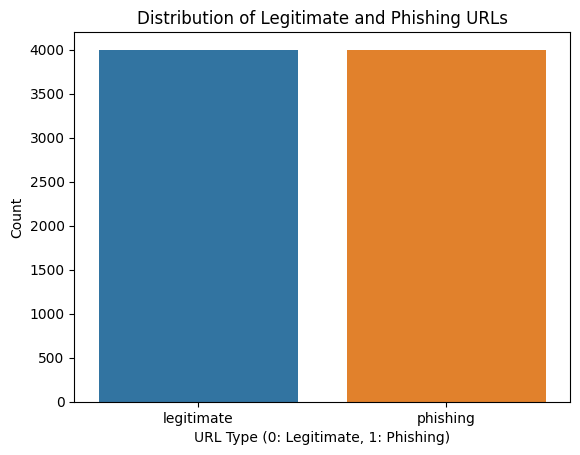

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(data=data, x='target', hue='target')
plt.title('Distribution of Legitimate and Phishing URLs')
plt.xlabel('URL Type (0: Legitimate, 1: Phishing)')
plt.ylabel('Count')
plt.show()